# Overview

**GENERAL THOUGHTS:**
- How to handle SKUs with mulitple components? Does it make more sense to combine them into a single row? -> might want to try this as a next step


**DATA PREPROCESSING:**

Imbalanced data:
- over_sampling for imbalanced data
- cost-sensitive learning for imbalanced data

categorical data:
- Ordinal Data: The categories have an inherent order
- Nominal Data: The categories do not have an inherent order

Options:
- nominal encode 'material_number'
- nominal encode 'material_number_text'
- nominal encode 'brand'
- nominal encode 'product_area'
- ...


**MULTI-CLASS CLASSIFIER:**
- Focus on "Native Multiclass Classifiers" as a starting point. Might try "Binary Transformation" or "Hierarchical Classification" later. https://www.projectpro.io/article/multi-class-classification-python-example/547
- Overview models to be considered:  
X: to be considered
  - [ ] Naive Bayes 
  - [ ] Decision Trees
  - [X] K-Nearest Neighbors
  - [X] Ensemble Models (~~Random Forest~~, XGBoost)
  - [] Neural Networks


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn import set_config
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV, HalvingRandomSearchCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, OneHotEncoder, MinMaxScaler, StandardScaler
from sklearn.preprocessing import PowerTransformer
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import classification_report
from sklearn.utils import class_weight
from sklearn.utils.class_weight import compute_sample_weight

from sklearn.dummy import DummyClassifier
from sklearn.base import BaseEstimator, ClassifierMixin

from sklearn.ensemble import RandomForestClassifier

# import xgboost as xgb
# import lightgbm as lgbm

# import imblearn

from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform


In [3]:
SEED = 42

In [4]:
from typing import Dict, Iterable, List, Optional, Tuple, Union, Literal

import lightning as L
# from sklearn.preprocessing import StandardScaler
import torch
import torch.nn.functional as F
import torchmetrics
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.dataset import random_split

/opt/anaconda3/envs/py_ml_packaging_classification/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Load Data using Dataset Class

In [5]:
# # NOTE: Class to create custom dataset to follow PyTorch Lightning conventions eventhough we are working on tabular data,
# #       where the data for feature variables and the target variable are often already provided in a combined way (e.g. contrary to images and corresbonding labels).
# class TabularDatasetPACKAGING(Dataset):
#     def __init__(self, data_dir: str = None, transform=None):
#         """
#         This class is customized to the 'PACKAGING' use case and the related data.
#         Dataset to load Tabular Data as a Pandas DataFrame from a .csv file.
#         Loads the data as a Pandas DataFrame and performs custom data processing
#         related to loading a .csv file (data type correction) and defining a subset of features.
#         NOTE: In addition, the original intention of using a Torch Dataset Class, is to provide the output of the data
#         as tensors for further use of pytorch and to enable tensor operations. For our (and most) tabular datasets we neglect this aspect,
#         since we want to do the data transformations, which are not tensor based, within L.LightningDataModule.

#         Args:
#             data_dir: Path to the .csv file to be loaded as a Pandas DataFrame.
#         Returns:
#             dataset: Pandas Dataframe
#         """
#         self.data_dir = data_dir
#         self.transform = transform

#         self.data = pd.read_csv(self.data_dir, sep='\t')

#         # for inference mode, as the target might not be provided in the data,
#         # ensures pre-processing pipeline completes correctly.
#         if 'packaging_category' not in self.data.columns:
#             # Insert an empty column at the end (position=-1)
#             self.data.insert(len(self.data.columns), 'packaging_category', np.nan)

#         # select a subset
#         self.data = self.data[[
#             'material_number',
#             'brand',
#             'product_area',
#             'core_segment',
#             'component',
#             'manufactoring_location',
#             'characteristic_value',
#             'material_weight', 
#             'packaging_code',
#             'packaging_category',
#         ]]

#         self.data['material_number'] = self.data['material_number'].astype('object')

#         self.n_samples = self.data.shape[0]


#     @property
#     def get_dataframe(self):
#         """Returns the data as a pandas dataframe."""
#         return self.data


#     def __getitem__(self, idx):
#         """
#         Generates one single sample of data of the dataset (row)
#         and applies transformations to that sample if defined.
#         Called iteratively based on batches and batch_size.
#         """
#         sample = self.data[idx]

#         if self.transform is not None:
#             sample = self.transform(sample)

#         return sample
    
    
#     def __len__(self):
#         """Denotes the total number of samples."""
#         return self.n_samples

## Datasets, DataLoaders & LightningDataModule
- Logic of using `Datasets`, `DataLoaders` & `LightningDataModule` for **Tabular Data**  
    Since we are using tabular data and want to perform non tensor based processing to our date, we use Datasets, DataLoaders & LightningDataModule in a different manner as we would do when applying tensor operations (incl. tensor based preprpcessing) only.  
    - `LightningDataModule` 
        Our LightningDataModule builds the wrapper around this process, with the following intensions:
        - `def prepare_data`  
        Data Operations that only should be performed once on the data (and should not be performed on a distributed manner). Prepares the data for data pre-processing e.g. using sklearn.  
            - Loading the data from .csv to pd.DataFrame
            - General dataset preperations like feature selection and data type correction
        - `def setup`  
        First, data operations (like shuffle, split data, categorical encoding, normalization, etc.), which any dataframe should undergo before feeding into the dataloader will be performed here. Since we use sklearn functionalities for our tabular pre-processing pipeline the data input and output of the pre-processing is a tabular format (dataframe) and not a tensor format.
        Second, the outcome of `def setup` are `Dataset` objects for each split (e.g. train, val, test, pred), which is a wrapper around the pre-processed tabular data and provides the samples and their corresponding labels (ideally in tensor format) in a specific way to be compatible for the model(s).
            - `Dataset`  
            Dataset provides the samples and their corresponding labels in a specific way to be compatible for the model(s). We define the input for our tabular use case as a DataFrame, while the output should generally be a tensor. In our case the output is a tuple of a flattern tensor representing all features and a tensor for the target variable (label). This aligns with the input if a simple MLP model. For more complex models, e.g. that handle continous and categorical variables differently, this should be adapted.  
            The class performs specific data type correction for to use of Neural Networks (e.g. ensure that all outputs are numeric values of the correct type depeding of they are categorical or continous nature).
        - `def train/val/test/prediction_dataloader`  
        Creates our dataloaders within the LightningDataModule. See usage below.
            - `DataLoader` 
            DataLoader wraps an iterable around the Dataset to enable easy access to the samples during training and inference. The Dataset defines the format of the data that is passed to our model. The DataLoader retrieves our dataset’s features and labels. While training a model, we typically want to pass samples in “minibatches”, reshuffle the data at every epoch to reduce model overfitting, and use Python’s multiprocessing to speed up data retrieval, which is handled by the DataLoader. Input and output is a tensor. https://pytorch.org/tutorials/beginner/basics/data_tutorial.html

- Excorsion: Classical approach of using `Datasets`, `DataLoaders` & `LightningDataModule` for e.g. images, ...  
The main difference is the usage of tensors instead of a dataframe for efficent GPU usage.
    - `LightningDataModule` 
        Our LightningDataModule builds the wrapper around this process. It encapsulates training, validation, testing, and prediction dataloaders, as well as any necessary steps for data processing, downloads, and transformations. https://lightning.ai/docs/pytorch/stable/data/datamodule.html
        - `def prepare_data`  
        Loads the data and does general processing befor transfomring to a tensor, so efficent tensor operations can be enabled in `setup'.
        - `def setup`  
        Efficent tensor operations (like shuffle, split data, categorical encoding, normalization, etc.), which any dataframe should undergo before feeding into the dataloader.
        - `def train/val/test_dataloader`  
        Creates our dataloaders within the LightningDataModule.
    - `Dataset`
    Class to create tabular dataset to follow PyTorch Lightning conventions (eventhough we are working on tabular data), where the data for feature variables and the target variable are often already provided in a combined way (e.g. contrary to images and corresbonding labels). For "classical" approaches a Dataset class is often used at the start of the machine learning pipeline to provide the data in a format (e.g. combine images and corresponding labels, which are typically not provided in the same file) for further processing and training.

In [18]:
class TabularDataset(Dataset):
    def __init__(
            self,
            data: pd.DataFrame = None,
            continuous_cols: List[str] = None,
            categorical_cols: List[str] = None,
            target: List[str] = None,
            task: Literal['classification', 'regression'] = 'classification',
    ):
        """
        This class is customized for tabular related data for the use of classification and regression. Returns the tabular data as tensor format.
        Input data must be of numeric nature and should be ordinal or label encoded. This should be covered by a related LightningDataModule.
        Besides the standard functionality of the 'Dataset' class it provides data type correction to fit the requirements of Neural Networks and for efficent use of Neural Networks.
        NOTE: The original intention of using a Torch Dataset Class, is to provide the output of the data as tensors for further use of pytorch
        and to enable tensor operations. For our (and most) tabular datasets we neglect the aspect of tensor operations, since we do the data transformations (e.g. using sklearn),
        which are not tensor based, within L.LightningDataModule. The TabularDataset class is used to provide the data as tensors to the DataLoaders as a final step after data prepressing.

        Args:
            data (DataFrame): Pandas DataFrame to load during training.
            continuous_cols (List[str], optional): A list of names of continuous columns.
            categorical_cols (List[str], optional): A list of names of categorical columns. These columns must be ordinal or label encoded beforehand.
            target (List[str], optional): A list of strings with target column name(s).
            task (str, optional): Whether it is a classification or regression task. If classification, it returns a LongTensor as target.
        Returns:
            Corrected tabular data as tensor format.
        """
        # self.data = data
        self.task = task
        self.n_samples = data.shape[0]
        self.categorical_cols = categorical_cols
        self.continuous_cols = continuous_cols
        self.target = target

        # NOTE: input data must be ordinal or label encoded

        # target handling
        if self.target:
            self.y = data[self.target].astype(np.float32).values # for regression task
            if self.task == "classification":
                self.y = self.y.reshape(-1, 1).astype(np.int64) # for classification task
        else:
            self.y = np.zeros((self.n_samples, 1))  # for regression task
            if self.task == "classification":
                self.y = self.y.astype(np.int64) # for classification task
        
        # feature handling
        self.categorical_cols = self.categorical_cols if self.categorical_cols else []
        self.continuous_cols = self.continuous_cols if self.continuous_cols else []
        if self.continuous_cols:
            self.continuous_X = data[self.continuous_cols].astype(np.float32).values
        if self.categorical_cols:
            self.categorical_X = data[self.categorical_cols]
            self.categorical_X = self.categorical_X.astype(np.int64).values


    @property
    def get_dataframe(self):
        """Creates and returns the dataset as a pandas dataframe."""
        if self.continuous_cols or self.categorical_cols:
            df = pd.DataFrame(
                np.concatenate([self.categorical_X, self.continuous_X], axis=1),
                columns=self.categorical_cols + self.continuous_cols,
            )
        else:
            df = pd.DataFrame()
        df[self.target] = self.y # add target column

        return df
    

    def __len__(self):
        """Returns the total number of samples in the dataset."""
        return self.n_samples


    def __getitem__(self, idx) -> Tuple[Dict[str, torch.Tensor], torch.Tensor]:
        """
        Generates one single sample of data of the dataset (row)
        and applies transformations to that sample if defined.
        Called iteratively based on batches and batch_size.
        Args:
            idx (int): index (between ``0`` and ``len(dataset) - 1``)

        Returns:
            Tuple[Dict[str, torch.Tensor], torch.Tensor]: x and y for model
        """

        # return {
        #     "features": (torch.Tensor(np.concatenate([self.categorical_X[idx], self.continuous_X[idx]], axis=1)) if (self.continuous_cols or self.categorical_cols) else torch.Tensor()),
        #     "target": torch.Tensor(self.target[idx])
        # }
        return {
            "continuous": (torch.Tensor(self.continuous_X[idx]) if self.continuous_cols else torch.Tensor()),
            "categorical": (torch.Tensor(self.categorical_X[idx]) if self.categorical_cols else torch.Tensor()),
            "target": torch.Tensor(self.target[idx])
        }

# Pre-process Data using DataLoader Class

In [19]:
class TabularDataModuleClassificationPACKAGING(L.LightningDataModule):
    """
    The class processes the data accordingly, so that the output meets the requirments to be further used by PyTorch/Lightning.
    A shareble, reusable class that encapsulates data loading and data preprocessing logic for classification.
    The class provides general data handeling and very specific data handeling to the 'Packaging Dataset' ('number` and 'object' types as variables are supported, but no other e.g. like 'date').
    NOTE: In addition, the original intention of using a L.LightningDataModule is to performe data operations on tensors to improve compute performance. For our (and most) tabular datasets we neglect this aspect,
    since we perform data transformations, which are not tensor based. Therefore data preprocessing and transformations are organized within the class methods 'prepare_data' and 'setup',
    based on if they should be performed a single time only or multiple times.
    NOTE: Be aware of the status of your transformers (data they are fit on) - performance optimization vs. final evaluation vs. inference only.

    Args:
        L (_type_): _description_
    """
    def __init__(
        self,
        data_dir: str,
        continuous_cols: List[str] = None,
        categorical_cols: List[str] = None,
        target: List[str] = None,
        task: Literal['classification', 'regression'] = 'classification',
        batch_size: int = 64,
        batch_size_inference: Optional[int] = None,
        SEED: Optional[int] = 42
    ):
        super().__init__()
        self.data_dir = data_dir
        self.categorical_cols = categorical_cols if categorical_cols else []
        self.continuous_cols = continuous_cols if continuous_cols else []
        self.task = task
        self.target = target
        self.batch_size = batch_size
        self.batch_size_inference = self.batch_size if not batch_size_inference else batch_size_inference
        self.SEED = SEED

        self._prepare_data_called = False
        # self._setup_called = False

    def _prepare_data(self, data: pd.DataFrame) -> pd.DataFrame:
        """
        Performs general, use case independent data input handeling and data type handling.
        Used internal in 'prepare_data' for train, val and test dataloaders and in 'inference_dataloader' for prediction.
        Target specific handelings are performed in 'perpare_data' to avoid conflicts during inference only scenarios where the target is not available.
        General data preparation involves:
            - transform target variable to data type 'object' for classificatiomn tasks and to data type 'float32' for regression tasks.
            - transform continuous feature variables to data type 'np.float32'.
            - transform categorical feature variables to data type 'object'.
            - update the processed dataframe accordingly and drops not specified columns.
        """
        if self.task == 'classification':
            # transform target variable to data type 'object'
            data[self.target] = data[self.target].astype('object').values
        elif self.task == 'regression':
            # transform target variable to data type 'float32'
            data[self.target] = data[self.target].astype(np.float32).values

        if len(self.continuous_cols) > 0:
            # continuous_cols will be transfomred to float32 ('32' for performance reasons) since NNs do not handle int properly.
            data[self.continuous_cols] = data[self.continuous_cols].astype(np.float32).values
        if len(self.categorical_cols) > 0:
            # ensure that all categorical variables are of type 'object'
            data[self.categorical_cols] = data[self.categorical_cols].astype('object').values
            
        if (len(self.continuous_cols) > 0) or (len(self.categorical_cols) > 0):
            # self.feature_cols = self.continuous_cols + self.categorical_cols
            pass
        else:
            raise TypeError("Missing required argument: 'continuous_cols' and/or 'categorical_cols'")
        
        # Define a subset based on continuous_cols and categorical_cols
        data = data[self.continuous_cols + self.categorical_cols + self.target]

        return data


    def _preprocessing_pipeline(self, X: pd.DataFrame = None, y: pd.DataFrame = None, stage: str = 'fit') -> pd.DataFrame:
        """
        PREPROCESSING PIPELINE
        Used internal in 'setup' for train, val and test dataloaders and in 'inference_dataloader',
        as well as for inverse transformations.
        NOTE: TabularDatasetPACKAGING prepares data for prediction only accordingly to support _preprocessing_pipeline.
        """
        
        # create pipeline for fit scenario, use existing pipeline for inference scenario
        if stage == 'fit':
            # numerical feature processing
            numerical_features = X.select_dtypes(include='number').columns.tolist()
            numeric_feature_pipeline = Pipeline(steps=[
                ('impute', SimpleImputer(strategy='median')),
                ('scale', StandardScaler())
            ])
            # categorical feature processing
            categorical_features = X.select_dtypes(exclude='number').columns.tolist()
            categorical_feature_pipeline = Pipeline(steps=[
                ('impute', SimpleImputer(strategy='most_frequent')),
                # ('label', LabelEncoder()),
                ('ordinal', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)), # ordinal is used instead of label encoder to avoid conflicts with inference or 
                #conflicts caused by data splits of categories with low numerber of classesonly scenarios
                # ('one_hot', OneHotEncoder(handle_unknown='ignore', max_categories=None, sparse_output=False))
            ])
            # apply both pipeline on seperate columns using "ColumnTransformer"
            self.preprocess_pipeline = ColumnTransformer(transformers=[
                ('number', numeric_feature_pipeline, numerical_features),
                ('category', categorical_feature_pipeline, categorical_features)],
                verbose_feature_names_out=False)
            self.preprocess_pipeline.set_output(transform="pandas")

            # ordinal is used instead of label encoder to avoid conflicts with inference or 
            # conflicts caused by data splits of categories with low numerber of classesonly scenarios
            self.label_encoder_target = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1) 
            # self.label_encoder_target = LabelEncoder()
        
        if stage == 'fit':
            X_transformed = self.preprocess_pipeline.fit_transform(X)
            y_transformed = pd.DataFrame(data=self.label_encoder_target.fit_transform(y.values.reshape(-1, 1)), index=y.index, columns=y.columns)
        elif stage == 'inference':
            X_transformed = self.preprocess_pipeline.transform(X)
            y_transformed = pd.DataFrame(data=self.label_encoder_target.transform(y.values.reshape(-1, 1)), index=y.index, columns=y.columns)
        else:
            raise TypeError("Missing required argument 'stage', must be 'fit' or 'inference'")
        
        return pd.concat([X_transformed, y_transformed], axis=1)
    

    def prepare_data(self, shuffle: bool = False):
        """ Custom data specific operations and basic tabular specific operations that only should be performed once on the data (and should not be performed on a distributed manner).
        Load the data as Tabular Data as a Pandas DataFrame from a .csv file and performs custom data processing related to loading a .csv file (data type correction) and defining a subset of features.
        In addition "_prepare_data" performace general data preparation for the classification/regression task and perform basic data error handeling. General data preparation involves:
            - transform target variable to data type 'object'.
            - update the processed dataframe accordingly and drops not specified columns.
            - shuffle the data (rows).
        """

        # USE CASE SPECIFIC DATA HANDLING
        self.data = pd.read_csv(self.data_dir, sep='\t')
        # for inference mode, as the target might not be provided in the data,
        # ensures pre-processing pipeline completes correctly.
        if 'packaging_category' not in self.data.columns:
            # Insert an empty column at the end (position=-1)
            self.data.insert(len(self.data.columns), 'packaging_category', np.nan)
        # select a subset
        self.data = self.data[[
            'material_number',
            'brand',
            'product_area',
            'core_segment',
            'component',
            'manufactoring_location',
            'characteristic_value',
            'material_weight', 
            'packaging_code',
            'packaging_category',
        ]]
        self.data['material_number'] = self.data['material_number'].astype('object')

        # GENERAL DATA HANDLING
        self.data = self._prepare_data(self.data)

        # shuffle data
        if shuffle is True: self.data = self.data.sample(frac=1)

        self.n_samples = self.data.shape[0]

        self._prepare_data_called = True

    
    def setup(
        self,
        test_size: Optional[float] = None,
        val_size: Optional[float] = None,
        stage_setup: str = None
    ) -> None:
        """
        Data Operations (like shuffle, split data, categorical encoding, normalization, etc.) that will be performed multiple times (on each single GPU indipendently), which any dataframe should undergo before feeding into the dataloader.
        Since on tabular data, operations like transformations (categorical encoding, normalization, etc.) needs to be performed with respect to all samples (respectively separat per train, val, test split),
        most operations are not performed in DDP way. See class docstring for further details regarding tabular data and tensor transformations.

        Args:
            test_size (Optional[float], optional):
                Defines the hold out split that should be used for final performance evaluation. If 'None' no split will be performed and all data is used in 'fit'
            val_size (Optional[float], optional):
                Defines an additional split on the train data that should be used for model optimization. If 'None' no val split will be performed and all train data is used in 'fit'
            stage (Optional[str], optional):
                Internal parameter to distinguish between 'fit' and 'inference'. Defaults to None.

        TODO: check interaction of 'stage_setup' with Lightning Module inherent use of 'stage'.
        """
        self.val_size = val_size
        self.test_size = test_size

        if not self._prepare_data_called:
            raise RuntimeError("'prepare_data' needs to be called before 'setup'")

        # Define features and target
        X = self.data.iloc[:, :-1]
        y = self.data.iloc[:, -1]  # the last column is the target, ensured by calling 'prepare_data' upfront

        if stage_setup == 'fit':
            # Generate train, val and test data splits
            if self.test_size is not None:
                X_train, X_test, y_train, y_test = train_test_split(
                    X, y, test_size=self.test_size, stratify=y, random_state=self.SEED
                )
                X_train = pd.DataFrame(data=X_train, columns=X.columns)
                y_train = pd.DataFrame(data=y_train, columns=[y.name])
                X_test = pd.DataFrame(data=X_test, columns=X.columns)
                y_test = pd.DataFrame(data=y_test, columns=[y.name])
                if (self.val_size is not None) and (self.test_size is not None):
                    X_train, X_val, y_train, y_val = train_test_split(
                        X_train, y_train, test_size=self.val_size, stratify=y_train, random_state=self.SEED
                    )
                    X_train = pd.DataFrame(data=X_train, columns=X.columns)
                    y_train = pd.DataFrame(data=y_train, columns=[y.name])
                    X_val = pd.DataFrame(data=X_val, columns=X.columns)
                    y_val = pd.DataFrame(data=y_val, columns=[y.name])
            else:
                X_train = X
                y_train = y
        elif stage_setup == 'inference':
            X_pred = X
            y_pred = y
        else:
            raise TypeError("Missing required argument 'stage_setup', must be 'fit' or 'inference'")

        # pre-process data
        if stage_setup == 'fit':
            tabular_train = self._preprocessing_pipeline(X_train, y_train, stage='fit')
            if self.test_size is not None:
                tabular_test = self._preprocessing_pipeline(X_test, y_test, stage='inference')
            if (self.val_size is not None) and (self.test_size is not None):
                tabular_val = self._preprocessing_pipeline(X_val, y_val, stage='inference')
        elif stage_setup == 'inference':
            tabular_predict = self._preprocessing_pipeline(X_pred, y_pred, stage='inference')

        # create datasets
        if stage_setup == 'fit':
            self.train_dataset = TabularDataset(
                    data=tabular_train,
                    continuous_cols=self.continuous_cols,
                    categorical_cols=self.categorical_cols,
                    target=self.target,
                    task='classification'
                )
            if self.test_size is not None:
                self.test_dataset = TabularDataset(
                    data=tabular_test,
                    continuous_cols=self.continuous_cols,
                    categorical_cols=self.categorical_cols,
                    target=self.target,
                    task='classification'
                )
            if (self.val_size is not None) and (self.test_size is not None):
                self.val_dataset = TabularDataset(
                    data=tabular_val,
                    continuous_cols=self.continuous_cols,
                    categorical_cols=self.categorical_cols,
                    target=self.target,
                    task='classification'
                )
        elif stage_setup == 'inference':
            self.predict_dataset = TabularDataset(
                data=tabular_predict,
                continuous_cols=self.continuous_cols,
                categorical_cols=self.categorical_cols,
                target=self.target,
                task='classification'
            )
    
        # self._setup_called = True

    def train_dataloader(self) -> DataLoader:
        """Dataloader that the Trainer fit() method uses.
        Args:
            batch_size (Optional[int], optional): Batch size. Defaults to `self.batch_size`.
        Returns:
            DataLoader: Train dataloader
        """
        # if not self._setup_called:
        #     raise RuntimeError("'setup' needs to be called before 'train_dataloader'")
        return DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True, drop_last=True)

    def val_dataloader(self) -> DataLoader:
        """Dataloader that the Trainer fit() and validate() methods uses.
        Args:
            batch_size (Optional[int], optional): Batch size. Defaults to `self.batch_size`.
        Returns:
            DataLoader: Validation dataloader
        """
        # if not self._setup_called:
        #     raise RuntimeError("'setup' needs to be called before 'val_dataloader'")
        return DataLoader(self.val_dataset, batch_size=self.batch_size, shuffle=False)

    def test_dataloader(self) -> DataLoader:
        """Dataloader that the Trainer test() method uses.
        """
        # if not self._setup_called:
        #     raise RuntimeError("'setup' needs to be called before 'test_dataloader'")
        return DataLoader(self.test_dataset, batch_size=self.batch_size, shuffle=False)

    # if self.stage == 'inference':
        # def predict_dataloader(self) -> DataLoader:
        #     """Dataloader that the Trainer predict() method uses.
        #     Used for predictions for data with unknow target (labes) by performing the following:
        #     - creates TabularDatasetPACKAGING dataset from csv file. TabularDatasetPACKAGING prepares data for prediction only accordingly to support _preprocessing_pipeline.
        #     - _prepare_data
        #     - _preprocessing_pipeline
        #     """
        #     return DataLoader(self.predict_dataset, batch_size=self.batch_size_inference, shuffle=False)
    

In [20]:
dm = TabularDataModuleClassificationPACKAGING(
    data_dir='../../data/output/df_ml.csv',
    continuous_cols=['material_weight'],
    categorical_cols=[
        'material_number',
        'brand',
        'product_area',
        'core_segment',
        'component',
        'manufactoring_location',
        'characteristic_value',
        'packaging_code'
    ],
    target=['packaging_category'],
    batch_size=64,
    SEED=SEED # Ensure same data split as in other notebooks
)

In [21]:
dm.prepare_data()
dm.data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82977 entries, 0 to 82976
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   material_weight         75913 non-null  float32
 1   material_number         82977 non-null  object 
 2   brand                   82977 non-null  object 
 3   product_area            82977 non-null  object 
 4   core_segment            82977 non-null  object 
 5   component               82977 non-null  object 
 6   manufactoring_location  82977 non-null  object 
 7   characteristic_value    82977 non-null  object 
 8   packaging_code          82977 non-null  object 
 9   packaging_category      82977 non-null  object 
dtypes: float32(1), object(9)
memory usage: 6.0+ MB


In [22]:
dm.setup(test_size=0.2, val_size=0.2, stage_setup='fit')

In [23]:
print(f"train_dataloader: {type(dm.train_dataloader())}")
dm.train_dataloader()

train_dataloader: <class 'torch.utils.data.dataloader.DataLoader'>


In [17]:
# TODO: how to access the dict of the dataloader correctly?
# check correctness of DataModule
num_epochs = 1
for epoch in range(num_epochs):

    for batch_idx, (x, y) in enumerate(dm.train_dataloader()):
        if batch_idx >= 3:
            break
        print(" Batch index:", batch_idx, end="")
        print(" | Batch size:", y.shape[0], end="")
        print(" | x shape:", x.shape, end="")
        print(" | y shape:", y.shape)

print("Labels from current batch:", y)

IndexError: list index out of range

## NN without HPO

In [ ]:
class PyTorchMulticlassMLP(torch.nn.Module):
    def __init__(self, num_features, num_classes):
        super().__init__()

        self.all_layers = torch.nn.Sequential(
            # 1st hidden layer
            torch.nn.Linear(num_features, 50),
            torch.nn.ReLU(),
            # 2nd hidden layer
            torch.nn.Linear(50, 25),
            torch.nn.ReLU(),
            # output layer
            torch.nn.Linear(25, num_classes),
        )

    def forward(self, x):
        # x = torch.flatten(x, start_dim=1)
        logits = self.all_layers(x)
        return logits

In [ ]:
class LightningModel(L.LightningModule):
    def __init__(self, model, learning_rate, num_classes):
        super().__init__()

        self.learning_rate = learning_rate
        self.model = model

        self.train_acc = torchmetrics.Accuracy(task="multiclass", num_classes=num_classes)
        self.val_acc = torchmetrics.Accuracy(task="multiclass", num_classes=num_classes)
        self.test_acc = torchmetrics.Accuracy(task="multiclass", num_classes=num_classes)

    def forward(self, x):
        return self.model(x)

    def _shared_step(self, batch):
        '''Shared functionalities for train_step, val_step and test_step'''
        features, true_labels = batch
        logits = self(features)

        loss = F.cross_entropy(logits, true_labels)
        predicted_labels = torch.argmax(logits, dim=1)
        return loss, true_labels, predicted_labels

    def training_step(self, batch, batch_idx):
        loss, true_labels, predicted_labels = self._shared_step(batch)

        self.log("train_loss", loss)
        self.train_acc(predicted_labels, true_labels)
        self.log("train_acc", self.train_acc, prog_bar=True, on_epoch=True, on_step=False)
        return loss

    def validation_step(self, batch, batch_idx):
        loss, true_labels, predicted_labels = self._shared_step(batch)

        self.log("val_loss", loss, prog_bar=True)
        self.val_acc(predicted_labels, true_labels)
        self.log("val_acc", self.val_acc, prog_bar=True)

    def test_step(self, batch, batch_idx):
        _, true_labels, predicted_labels = self._shared_step(batch)
        self.test_acc(predicted_labels, true_labels)
        self.log("test_acc", self.test_acc)

    def configure_optimizers(self):
        optimizer = torch.optim.SGD(self.parameters(), lr=self.learning_rate)
        return optimizer

In [94]:
# DEFINE MODEL PIPELINE
# define model architecture
def multi_class_nn(n_features, n_classes, units_per_layer, dropout):
    
    model = Sequential()

    model.add(InputLayer(name='input', input_shape=(n_features,)))
    # model.add(normalizer)
    
    for idx, units in enumerate(units_per_layer):
        model.add(Dense(units, name=f'hidden_{idx+1}', activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

    model.add(Dense(units=n_classes, name='output', activation='softmax'))

    # compile
    model.compile(
        loss='categorical_crossentropy', # sparse for ordinal encoding
        optimizer='adam',
        metrics=['accuracy'],
    )

    return model

# class_weights
class_weights = class_weight.compute_class_weight(
    class_weight = "balanced",
    classes = np.unique(y_train.to_numpy()),
    y =  y_train.to_numpy()
)
class_weight_dict = dict(enumerate(class_weights))

# instanciate model
nn_clf = multi_class_nn(
    n_features = X_train_processed.shape[1],
    n_classes = y_train_encoded.shape[1],
    units_per_layer = [100, 100, 100],
    dropout = 0.2,
)

print(nn_clf.summary())
# print(tf.keras.utils.plot_model(nn_clf, show_shapes=True, show_layer_names=True))

# Training
# train data
onehot_encoder = OneHotEncoder(categories = 'auto')
y_train_encoded = pd.DataFrame(onehot_encoder.fit_transform(y_train.values.reshape(-1, 1)).toarray())
# Test data
X_test_processed = preprocess_pipeline.transform(X_test)
y_test_encoded = pd.DataFrame(onehot_encoder.transform(y_test.values.reshape(-1, 1)).toarray())
# train
history = nn_clf.fit(
    X_train_processed,
    y_train_encoded,
    class_weight=class_weight_dict,
    validation_data=(X_test_processed, y_test_encoded),
    epochs=100,
    batch_size=16,
    shuffle=True, # shuffels data randomly after each epoch
    # callbacks=[KerasLearningCurve()],
    verbose=1
)

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 hidden_1 (Dense)            (None, 100)               1000      
                                                                 
 batch_normalization_13 (Bat  (None, 100)              400       
 chNormalization)                                                
                                                                 
 dropout_13 (Dropout)        (None, 100)               0         
                                                                 
 hidden_2 (Dense)            (None, 100)               10100     
                                                                 
 batch_normalization_14 (Bat  (None, 100)              400       
 chNormalization)                                                
                                                                 
 dropout_14 (Dropout)        (None, 100)              

In [96]:
X_test_transformed  = preprocess_pipeline.transform(X_test)
y_preds = nn_clf.predict(X_test_transformed)

y_test_transformed = onehot_encoder.transform(y_test.values.reshape(-1, 1)).toarray()

print(classification_report(y_test_transformed, y_preds))

519/519 [==============================] - 0s 628us/step


ValueError: Classification metrics can't handle a mix of multilabel-indicator and continuous-multioutput targets

In [ ]:
df_hist = pd.DataFrame(history.history)
df_hist['epochs'] = history.epoch
df_hist.tail()

,loss,accuracy,val_loss,val_accuracy,epochs
45,4.070479,0.008934,1.153754e+10,0.000603,45
46,4.057920,0.011857,1.108053e+10,0.001386,46
47,4.031371,0.010652,8.056508e+09,0.000663,47
48,4.060278,0.008783,7.011128e+09,0.001446,48
49,3.989947,0.010109,9.626664e+09,0.001326,49


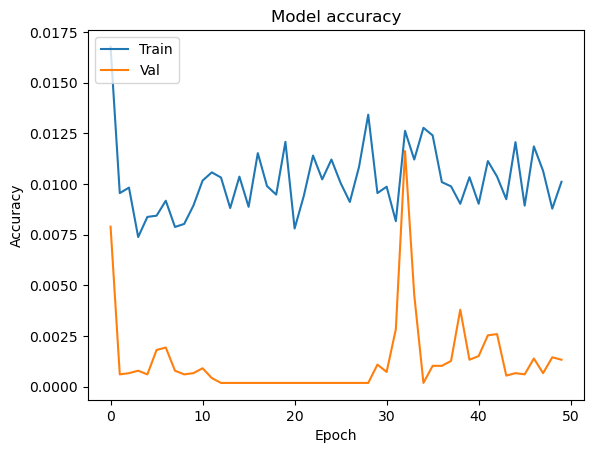

In [ ]:
# Plot training & validation accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')

## NN with HPO